# Analog Discovery: Analog IN OUT
- https://digilent.com/shop/analog-discovery-2-100ms-s-usb-oscilloscope-logic-analyzer-and-variable-power-supply/
- https://digilent.com/shop/software/digilent-waveforms/
- C:\Program Files (x86)\Digilent\WaveFormsSDK\WaveForms SDK Reference Manual.pdf

Divers
- https://www.embedded.com/using-python-to-simplify-noise-analysis-of-mixed-mode-signal-chains/

Installation der Kommunikationstreiber
1. digilent.waveforms_v3.xy_64bit.exe => https://digilent.com/shop/software/digilent-waveforms/
2. Kopieren der dwfconstants.py aus dem Installationsordner C:\Program Files (x86)\Digilent\WaveFormsSDK\samples\py\ in das Projektverzeichnis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dwfconstants import *
dwf = cdll.dwf
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import seaborn as sns
plt.style.use('dark_background')  # default https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.rcParams['figure.figsize'] = (8, 2)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 8
# plt.rcParams['font'] = {'size': 8}
# sns.set(rc={'figure.figsize':(5,5)})
# sns.color_palette('dark')  # https://seaborn.pydata.org/tutorial/color_palettes.html
# %matplotlib inline
# plt.rcParams.keys()

## Verdrahtung Messmittel
<img src="img/signaltest.jpg" width="300px" align="left"/>

## Signalberechnung

In [9]:
f = 1.0 * 10**3
T = 1 / f
buffer_size = 2**12 
sample_rate = int(f * buffer_size)
t = np.linspace(0.0, T, buffer_size)
print(f'{f = :1.0f}Hz | {T = }s | {buffer_size = } | {sample_rate = :1.0f}sps')    

amplitude = 3
signal_out_1 = np.sin(np.linspace(0, 2 * np.pi, buffer_size)) * amplitude
signal_out_2 = (np.heaviside(np.sin(np.linspace(0, 2 * np.pi, buffer_size)), np.zeros(buffer_size)) - 0.5) * 2 * amplitude

f = 1000Hz | T = 0.001s | buffer_size = 4096 | sample_rate = 4096000sps


In [10]:
hdwf = c_int()
rgdSamples = (c_double * buffer_size)()
channel = c_int(0)

# samples to c_double
for i in range(0, buffer_size, 1):
    # Ausgabe nur auf Kanal 1
    rgdSamples[i] = c_double(signal_out_1[i] * 0.2)  #Normierung des Signales auf +-1 => entspricht +-5V

version = create_string_buffer(16)
dwf.FDwfGetVersion(version)
print("DWF Version: "+str(version.value))

# open device
cdevices = c_int()
dwf.FDwfEnum(c_int(0), byref(cdevices))
print("Number of Devices: " + str(cdevices.value))

# print("Opening first device")
# hdwf = c_int()
dwf.FDwfDeviceOpen(c_int(0), byref(hdwf))

if cdevices.value == 0:
    print("no device available")
    quit()

if hdwf.value == hdwfNone.value:
    print("failed to open device")
    quit()

print("Generating custom waveform...")
dwf.FDwfAnalogOutNodeEnableSet(hdwf, channel, AnalogOutNodeCarrier, c_bool(True))
dwf.FDwfAnalogOutNodeFunctionSet(hdwf, channel, AnalogOutNodeCarrier, funcCustom) 
dwf.FDwfAnalogOutNodeDataSet(hdwf, channel, AnalogOutNodeCarrier, rgdSamples, c_int(buffer_size))
dwf.FDwfAnalogOutNodeFrequencySet(hdwf, channel, AnalogOutNodeCarrier, c_double(f)) 
dwf.FDwfAnalogOutNodeAmplitudeSet(hdwf, channel, AnalogOutNodeCarrier, c_double(5.0)) 
dwf.FDwfAnalogOutRunSet(hdwf, channel, c_double(T))  # run for 1 periods
dwf.FDwfAnalogOutWaitSet(hdwf, channel, c_double(0.0))  # wait 0.0 s
dwf.FDwfAnalogOutRepeatSet(hdwf, channel, c_int(500)) # repeat x times
# dwf.FDwfAnalogOutConfigure(hdwf, channel, c_bool(True))  # starte Signalgenerator

print('Einlesen der Analogsignale')
dwf.FDwfAnalogInFrequencySet(hdwf, c_double(sample_rate))
# print("Set range for all channels")
dwf.FDwfAnalogInChannelRangeSet(hdwf, c_int(-1), c_double(10.0))
dwf.FDwfAnalogInBufferSizeSet(hdwf, c_int(buffer_size))

# print("Wait after first device opening the analog in offset to stabilize")
# time.sleep(0.5)
print("Starting acquisition")
dwf.FDwfAnalogOutConfigure(hdwf, channel, c_bool(True))  # starte Signalgenerator
dwf.FDwfAnalogInConfigure(hdwf, c_int(1), c_int(1))

print("waiting to finish")
sts = c_int()
while True:
    dwf.FDwfAnalogInStatus(hdwf, c_int(1), byref(sts))
    if sts.value == DwfStateDone.value :
        break
    time.sleep(0.1)

# Daten aus dem Oszilloskop auslesen
# print("   reading data")
rg1 = (c_double * buffer_size)()
dwf.FDwfAnalogInStatusData(hdwf, c_int(0), rg1, len(rg1)) # get channel 1 data
rg2 = (c_double * buffer_size)()
dwf.FDwfAnalogInStatusData(hdwf, c_int(1), rg2, len(rg2)) # get channel 2 data

dwf.FDwfDeviceCloseAll()

ch1 = [0.0] * len(rg1) # Initialisieren
ch2 = [0.0] * len(rg2)
for i in range(0, len(ch1)):
    ch1[i] = rg1[i]
    ch2[i] = rg2[i]


signal_in_1 = np.array(copy.deepcopy(ch1))
signal_in_2 = np.array(copy.deepcopy(ch2))
    
# Signalgenerator deaktivieren
dwf.FDwfAnalogOutReset(hdwf, channel)
dwf.FDwfDeviceCloseAll()

print('finished')

DWF Version: b'3.18.1'
Number of Devices: 1
Generating custom waveform...
Einlesen der Analogsignale
Starting acquisition
waiting to finish
finished


---
## DAC Analogausgang

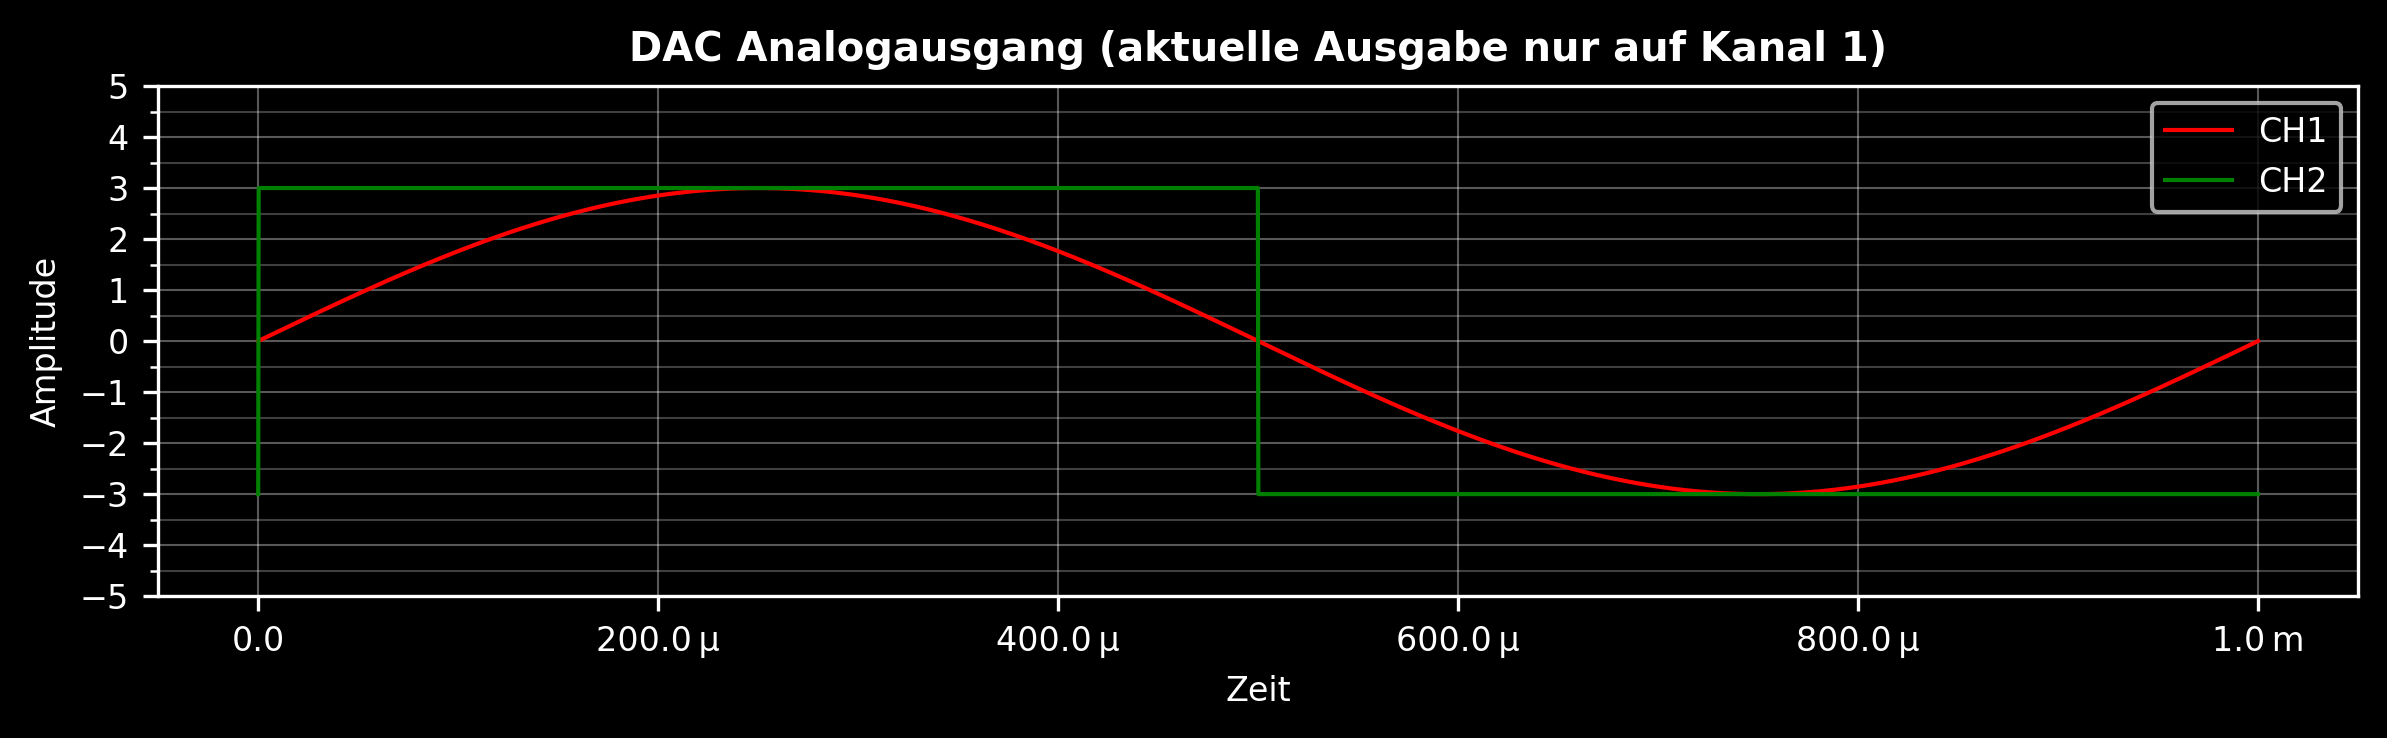

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
ax.plot(t, signal_out_1, lw=1, ls='-', marker='o', markersize=0, color='r', alpha=1.0, label='CH1')
ax.plot(t, signal_out_2, lw=1, ls='-', marker='o', markersize=0, color='g', alpha=1.0, label='CH2')
ax.xaxis.set_major_formatter(EngFormatter(places=1, sep="\N{THIN SPACE}"))
ax.set_ylim([-5.0, 5.0])
ax.set_yticks(np.linspace(-5, 5, 11))
ax.set_yticks(np.linspace(-5, 5, 21), minor=True)
ax.grid(which='major', color='w', alpha=0.35, ls='-', lw=0.5)  # both major minor
ax.grid(which='minor', color='w', alpha=0.25, ls='-', lw=0.5)
ax.set_title('DAC Analogausgang (aktuelle Ausgabe nur auf Kanal 1)', fontweight='bold')
ax.set_xlabel('Zeit')
ax.set_ylabel('Amplitude')
ax.legend(loc='best')  # best, upper left, upper center, upper right, center .., lower ..
fig.tight_layout()

---
## ADC Analogeingang

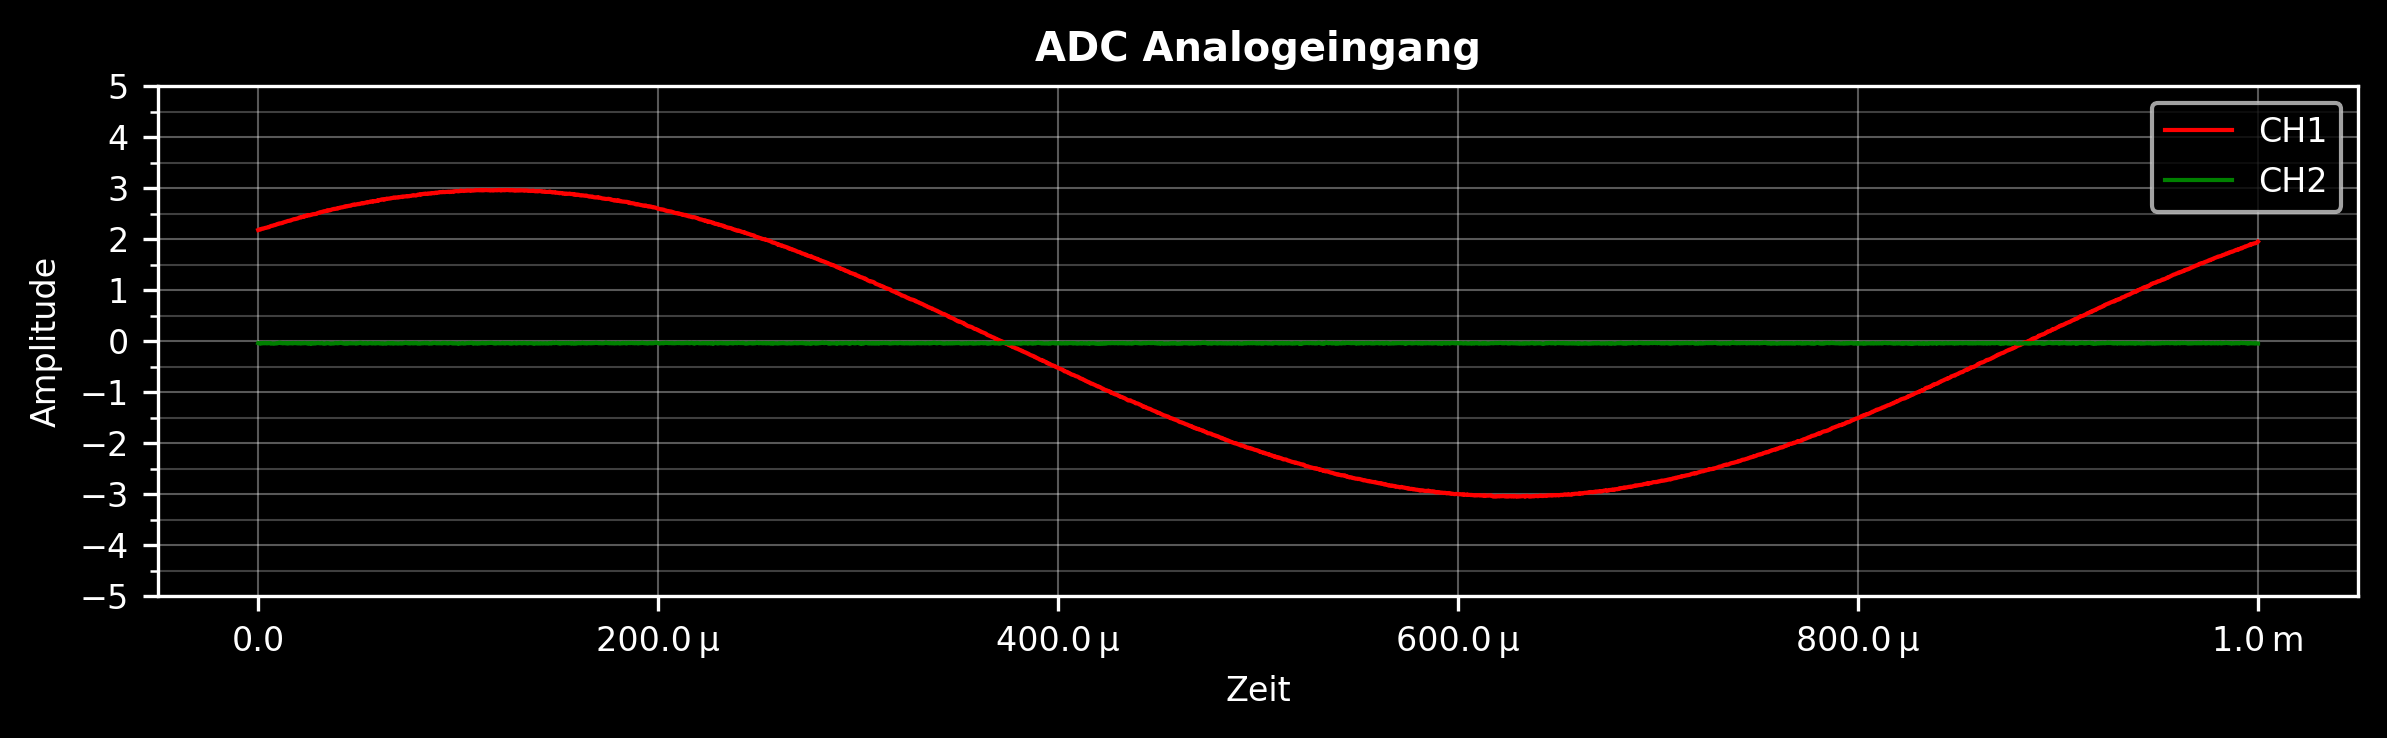

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2.5))
ax.plot(t, signal_in_1, lw=1, ls='-', marker='o', markersize=0, color='r', alpha=1.0, label='CH1')
ax.plot(t, signal_in_2, lw=1, ls='-', marker='o', markersize=0, color='g', alpha=1.0, label='CH2')
ax.xaxis.set_major_formatter(EngFormatter(places=1, sep="\N{THIN SPACE}"))
ax.set_ylim([-5.0, 5.0])
ax.set_yticks(np.linspace(-5, 5, 11))
ax.set_yticks(np.linspace(-5, 5, 21), minor=True)
ax.grid(which='major', color='w', alpha=0.35, ls='-', lw=0.5)  # both major minor
ax.grid(which='minor', color='w', alpha=0.25, ls='-', lw=0.5)
ax.set_title('ADC Analogeingang', fontweight='bold')
ax.set_xlabel('Zeit')
ax.set_ylabel('Amplitude')
ax.legend(loc='best')  # best, upper left, upper center, upper right, center .., lower ..
fig.tight_layout()

---

In [ ]:
# END